In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ahsang","key":"551be52b35e300692325e30b9ff8b472"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle kernels output shivamburnwal/speech-emotion-recognition -p /content/sample_data
!kaggle datasets list
!kaggle datasets download "ejlok1/cremad/versions/1" -p /content/sample_data/cremad/ --unzip
!kaggle datasets download "uwrfkaggler/ravdess-emotional-speech-audio" -p /content/sample_data/ravdess/ --unzip
!kaggle datasets download "ejlok1/surrey-audiovisual-expressed-emotion-savee" -p /content/sample_data/savee/ --unzip
!kaggle datasets download "ejlok1/toronto-emotional-speech-set-tess" -p /content/sample_data/tess/ --unzip


Kernel log downloaded to /content/sample_data/speech-emotion-recognition.log 
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           9669        293  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           5194        162  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44            730         43  

In [ ]:
# Paths for data.
Crema = "/content/sample_data/cremad/AudioWAV/"
Ravdess = "/content/sample_data/ravdess/"
Savee = "/content/sample_data/savee/ALL/"
Tess = "/content/sample_data/tess/TESS Toronto emotional speech set data/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        try:
          file_emotion.append(int(part[2]))
          file_path.append(Ravdess + dir + '/' + file)
        except:
          continue
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /content/sample_data/ravdess/Actor_22/03-01-08...
1     happy  /content/sample_data/ravdess/Actor_22/03-01-03...
2   disgust  /content/sample_data/ravdess/Actor_22/03-01-07...
3   neutral  /content/sample_data/ravdess/Actor_22/03-01-01...
4       sad  /content/sample_data/ravdess/Actor_22/03-01-04...

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    try:
      if part[2] == 'SAD':
          file_emotion.append('sad')
      elif part[2] == 'ANG':
          file_emotion.append('angry')
      elif part[2] == 'DIS':
          file_emotion.append('disgust')
      elif part[2] == 'FEA':
          file_emotion.append('fear')
      elif part[2] == 'HAP':
          file_emotion.append('happy')
      elif part[2] == 'NEU':
          file_emotion.append('neutral')
      else:
          file_emotion.append('Unknown')
    except:
      continue
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /content/sample_data/cremad/AudioWAV/1004_TSI_...
1    angry  /content/sample_data/cremad/AudioWAV/1014_IEO_...
2    happy  /content/sample_data/cremad/AudioWAV/1046_DFA_...
3  disgust  /content/sample_data/cremad/AudioWAV/1020_DFA_...
4      sad  /content/sample_data/cremad/AudioWAV/1091_WSI_...

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  neutral  /content/sample_data/tess/TESS Toronto emotion...
1  neutral  /content/sample_data/tess/TESS Toronto emotion...
2  neutral  /content/sample_data/tess/TESS Toronto emotion...
3  neutral  /content/sample_data/tess/TESS Toronto emotion...
4  neutral  /content/sample_data/tess/TESS Toronto emotion...

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                        Path
0    angry   /content/sample_data/savee/ALL/KL_a11.wav
1     fear   /content/sample_data/savee/ALL/JK_f04.wav
2      sad  /content/sample_data/savee/ALL/DC_sa15.wav
3    angry   /content/sample_data/savee/ALL/KL_a04.wav
4     fear   /content/sample_data/savee/ALL/KL_f06.wav

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /content/sample_data/ravdess/Actor_22/03-01-08...
1     happy  /content/sample_data/ravdess/Actor_22/03-01-03...
2   disgust  /content/sample_data/ravdess/Actor_22/03-01-07...
3   neutral  /content/sample_data/ravdess/Actor_22/03-01-01...
4       sad  /content/sample_data/ravdess/Actor_22/03-01-04...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


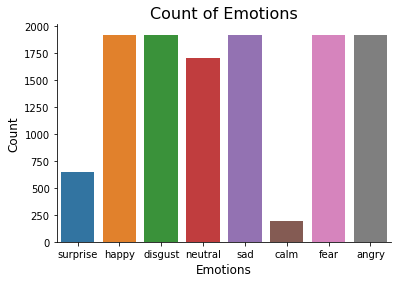

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

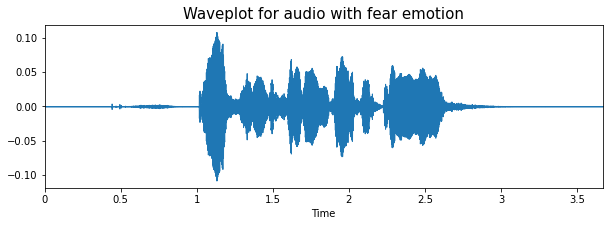

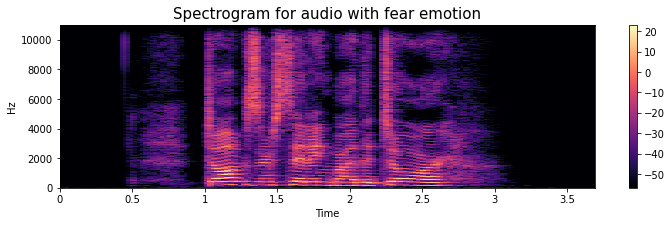

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

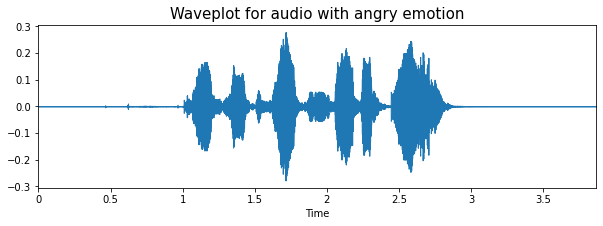

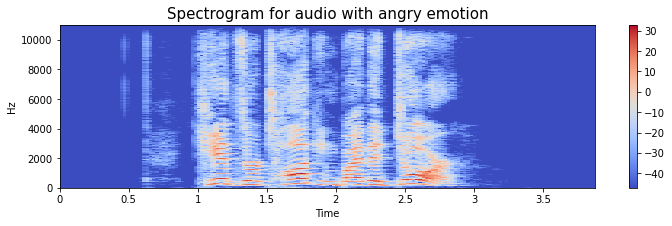

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

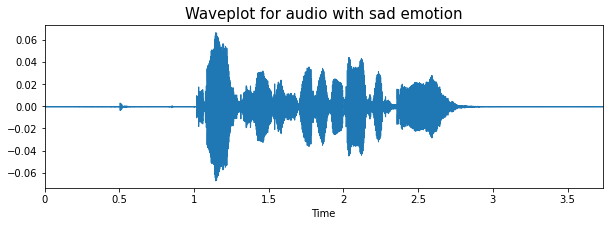

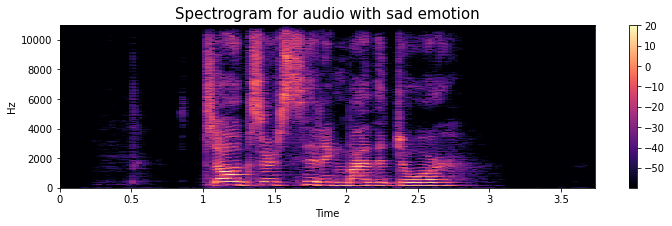

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

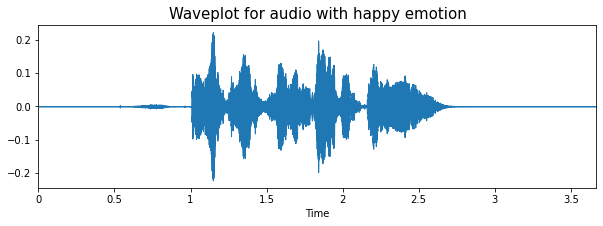

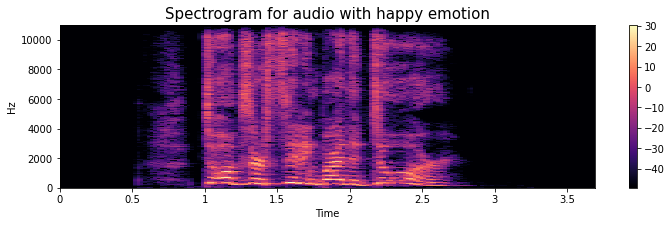

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [ ]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

In [ ]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

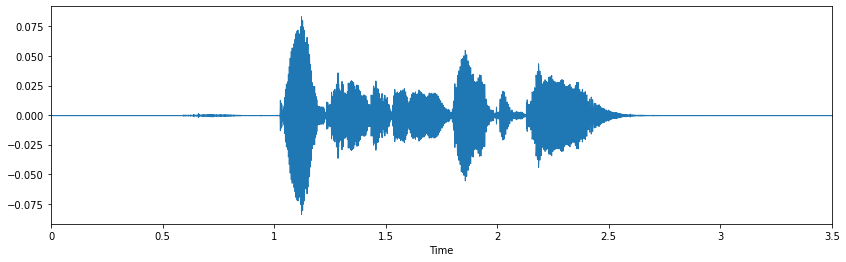

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

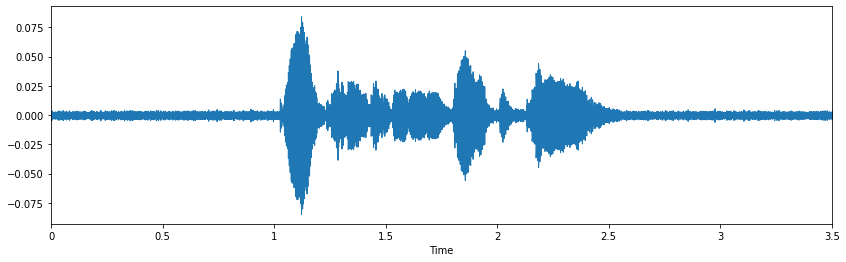

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

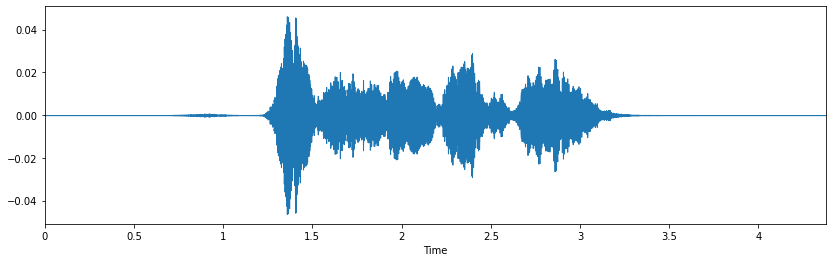

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

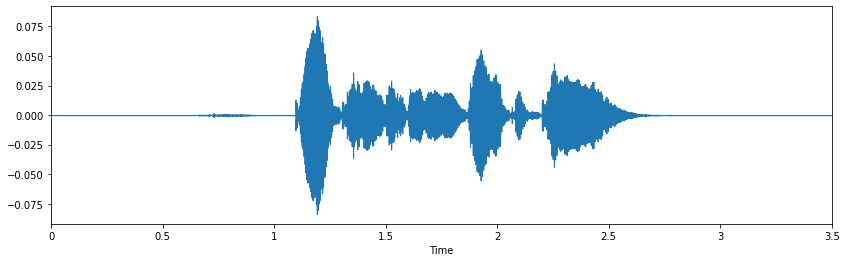

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

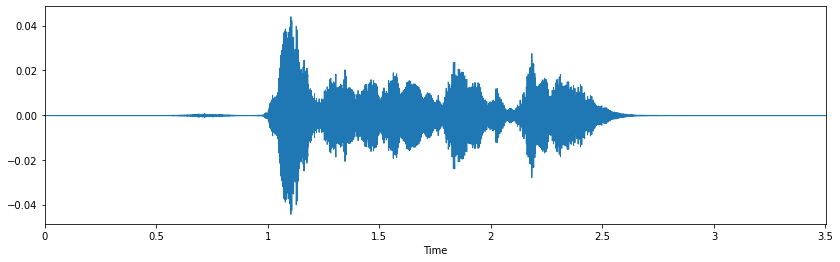

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.199146  0.484328  0.514981  0.588338  0.590693  0.609669  0.612963   
1  0.278099  0.601330  0.687575  0.719968  0.714607  0.683891  0.642223   
2  0.200872  0.511393  0.500956  0.592544  0.639379  0.618886  0.633092   
3  0.218013  0.542415  0.525268  0.589483  0.582981  0.612392  0.622106   
4  0.287996  0.682992  0.651332  0.639236  0.673745  0.704484  0.743300   

          7         8         9  ...       153       154       155       156  \
0  0.613369  0.593901  0.609873  ...  0.002360  0.003879  0.003320  0.002655   
1  0.616008  0.612953  0.668968  ...  0.002423  0.003976  0.003404  0.002735   
2  0.667126  0.664806  0.651194  ...  0.000216  0.000468  0.000668  0.000928   
3  0.619085  0.610682  0.611469  ...  0.000313  0.000314  0.000617  0.000293   
4  0.682485  0.665254  0.624212  ...  0.000390  0.000388  0.000697  0.000361   

        157       158       159       160       161    labels  
0  0.002905  0.003059  0.002034  0.000838  0.000083  surprise  
1  0.002971  0.003122  0.002146  0.000908  0.000158  surprise  
2  0.000517  0.000548  0.000498  0.000181  0.000007  surprise  
3  0.000210  0.000268  0.000164  0.000040  0.000003     happy  
4  0.000276  0.000336  0.000230  0.000118  0.000072     happy  

[5 rows x 163 columns]

## Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 18s 10ms/step - loss: 1.6889 - accuracy: 0.3194 - val_loss: 1.4670 - val_accuracy: 0.4063 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 4s 9ms/step - loss: 1.4456 - accuracy: 0.4220 - val_loss: 1.3078 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 4s 9ms/step - loss: 1.3549 - accuracy: 0.4591 - val_loss: 1.2645 - val_accuracy: 0.4939 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 4s 8ms/step - loss: 1.3046 - accuracy: 0.4786 - val_loss: 1.2243 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 4s 8ms/step - loss: 1.2718 - accuracy: 0.4910 - val_loss: 1.1971 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 4s 8ms/step - loss: 1.2386 - accuracy: 0.5037 - val_loss: 1.1649 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 4s 8ms/step - 

286/286 [==============================] - 1s 4ms/step - loss: 1.1073 - accuracy: 0.6194
Accuracy of our model on test data :  61.938172578811646 %


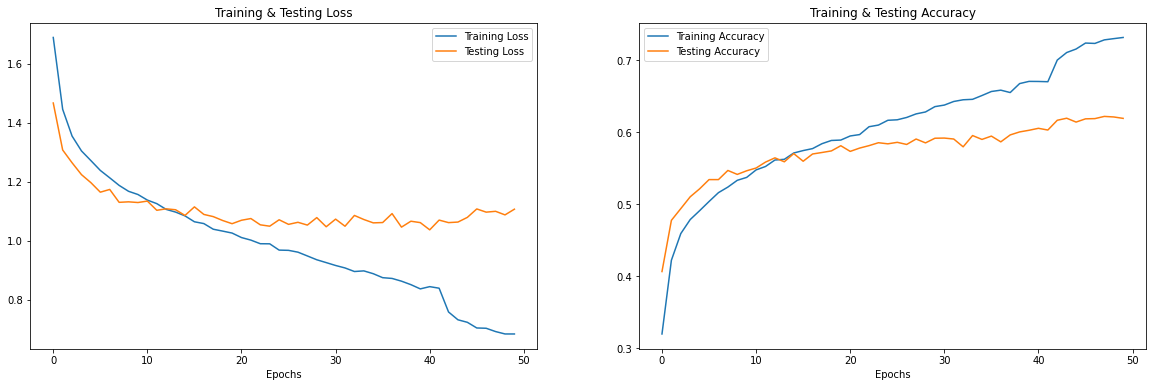

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1            angry         angry
2          neutral       neutral
3              sad           sad
4             fear          fear
5          neutral       neutral
6          disgust      surprise
7            happy         happy
8          neutral       neutral
9             fear          fear

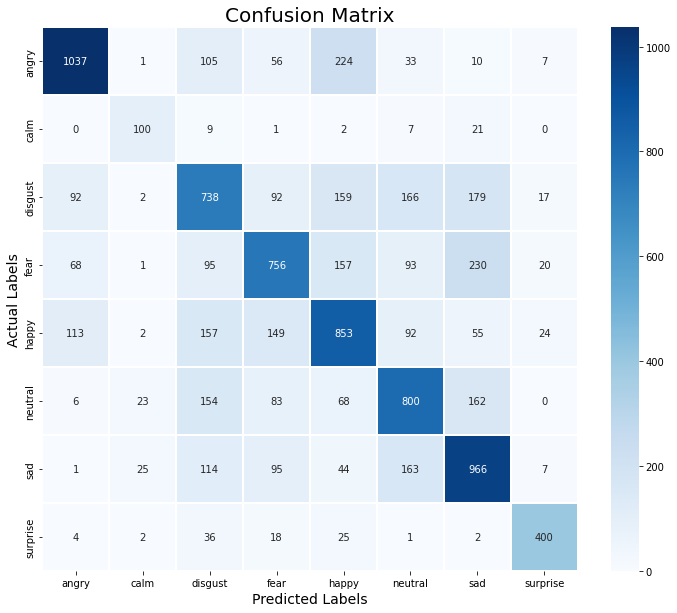

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.70      0.74      1473
        calm       0.64      0.71      0.68       140
     disgust       0.52      0.51      0.52      1445
        fear       0.60      0.53      0.57      1420
       happy       0.56      0.59      0.57      1445
     neutral       0.59      0.62      0.60      1296
         sad       0.59      0.68      0.64      1415
    surprise       0.84      0.82      0.83       488

    accuracy                           0.62      9122
   macro avg       0.64      0.65      0.64      9122
weighted avg       0.62      0.62      0.62      9122



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.